# PCA: Свой jpeg с блекджеком  и куртизантками

<img src='https://cs.pikabu.ru/post_img/2013/08/07/10/1375893075_408844834.jpg' width=400>

### 1. Как работает jpeg: в двух словах

Все изображение делится на квадраты 8х8 а затем каждый кусочек представляется в виде суммы из базисных кусочков 
(базисных векторов фурье-преобразования). 
Выбор именно такого базиса обусловлен универсальностью, но не обязательно наиболее выгоден для того или иного изображения. 

Выглядят базисные вектора jpeg вот так:
<img src='https://upload.wikimedia.org/wikipedia/commons/2/24/DCT-8x8.png' width=300>

Для тех кто хочет подробнее https://habrahabr.ru/post/206264/

(На самом деле там есть еще несколько этапов но нас интересует именно разложение в базис)

### 2. Задание
В качестве интересного способа практического применения PCA предлагаю вам сделать разложение на вектора, оптимальные для конкретного изображения (или набора изображений). Эти вектора мы можем легко получить, воспользовавшись SVD разложением.

Схема следующая:

Входные параметры - размер кусочков $n$ количество базисных векторов $d$
1. Разбиваем изображение на кусочки $n\times n$. всего получим $q=\frac{width*height}{n^2}$ кусочков
2. К каждому кусочку применяем `np.array.flatten()`. В итогe получаем матрицу $X$ размера $n^2\times q$
3. Делаем PCA, оставляем только $d$ компонент с наибольшими собственными значениями, получаем матрицу $d \times q$.(см код семинара)
4. Получившиеся вектора размера d переводим обратно в пространство размерности $n^2$ (см. код семинара)
5. применяем `numpy.reshape((n,n))`, cклеиваем кусочки обратно в том же порядке, что и разбивали
6. Выводим картинку и наслаждаемся результатом.
6. Визуализируем базисные вектора и сравниваем с джипеговскими (функция для визуализации прилагается)

Во время выполнения задания следите за размерностями матриц, чтоб избежать ошибок

### 3. Эксперименты
1. Посмотреть как меняется энтропия изображения и какая степень сжатия
2. Найти оптимальный размер $n$ и количество векторов $d$ 
3. Сравнить такой способ сжатия с <a href="https://docs.python.org/2/library/jpeg.html">jpeg</a>
4. Вычесть из исходного изображения сжатое, чтоб посмотреть какие пиксели отличаются.


### 4. Идеи для дальнейшего развития
1. Что если делить на маленькие квадраты, сжимать их не очень сильно, а получившиеся вектора меньшей размерности соединять в "большие квадраты" и к ним еще раз применять PCA (а потом еще раз и еще раз)?
2. Что если в случае маленькой дисперсии объединять квадраты в один и раскладывать в базис уже его?
3. Что если сделать параметром не количество базисных векторов а пороговую дисперсию? Иными словами - выбирать $d$ в зависимости от дисперии кусочка.
4. Что если сверточные сети обучать на таком представлении (матрица $d \times q$)?

Если возникли какие-то сложности пишите мне http://t.me/danlkv http://vk.com/danilozzz

Если получилось реализовать что-то из идей тоже пишите, мне самому очень интересно что будет.

Успехов!

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def plot_images_table(imgs, columns=8):
    n=len(imgs)
    h = (n-1)//columns+1
    f,ax=plt.subplots(h,columns,figsize=(10,10*h/columns))
    for i in range(1,n+1):
        ax[(i-1)//columns,i%columns-1].imshow(imgs[i-1],cmap='gray')
        
tt = np.random.randn(15,20,20)
plot_images_table(tt)

In [2]:
import requests
from PIL import Image
from io import BytesIO
# функция скачивает изображение по ссылке
def get_image(url):
    print("making request")
    r = requests.get(url)
    strio = BytesIO(r.content)
    i = Image.open(strio)
    print("got image with size %s"%str(np.array(i).shape))
    return i

In [3]:
# Эту функцию можно очень просто модифицировать для идеи #3
def pca(X,num_components):
    #X=np.array([l-np.mean(l) for l in X]) # Вычитаем среднее
    U,s,V=np.linalg.svd(X)                # Находим собственные вектора
    eps=np.sort(s)[-num_components]       # пороговое собственное значение (служебная строчка) 
    E = np.array([vec for val,vec in zip(s,V)
                  if val>eps])            # берем только важные вектора   (с большими собственными значениями)
    X_=np.dot(E,X.T).T                    # Преобразуем данные
    return X_,E

In [4]:
# Получаем изображение, разбиваем на кусочки
img = get_image('https://habrastorage.org/getpro/habr/post_images/a78/291/807/a7829180746c99c987384e4b2b6df7b8.png')
img = np.array(img)
n = 8
q = img.size // (n*n)
data = np.zeros((q, n, n), dtype =img.dtype)
w = img.shape[1]//n
for j in range(w):
    for i in range(img.shape[0]//n):
        data[i + j * w] = img[i*n:i*n+n, j*n:j*n+n]
print(data.shape)

making request
got image with size (256, 256)
(1024, 8, 8)


In [5]:
# Готовим матрицу объекторв, делаем PCA
d = 28
X = np.zeros((n*n, q), dtype = np.uint8)
for i in range(q):
    X[0:n*n, i] = data[i].flatten()
print(X.shape)

T,E = pca(X,d)
print(T.shape)
print(E.shape)

(64, 1024)
(64, 27)
(27, 1024)


In [6]:
# Переводим закодированные кусочки обратно в пространство где они имеют смысл изображения
reconstr = np.dot(T,E)
print(reconstr.shape)
img2 = np.zeros_like(img)

for k in range(q):
    i = k % w
    j = k // w
    img2[i*n:i*n+n, j*n:j*n+n] = reconstr[0:n*n,k].reshape((n,n))

(64, 1024)


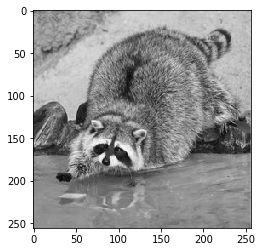

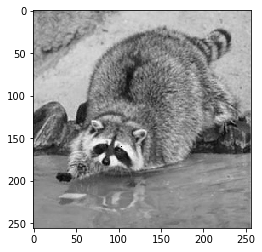

In [7]:
# Выводим картинку
plt.imshow(img,cmap='gray')
plt.figure()
plt.imshow(img2,cmap='gray')

(27, 8, 8)


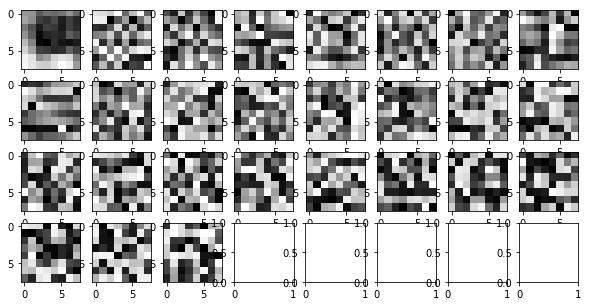

In [8]:
# Выводим базисные вектора
ts = np.zeros((d-1, n, n), dtype = np.uint8)
for k in range(d-1):
    i = k % w
    j = k // w
    ts[k] = T[0:n*n,k].reshape((8,8))
print(ts.shape)
plot_images_table(ts, 8)

In [9]:
# Эксперименты
import scipy.stats
def softmax(x):
    return np.power(x,2.1828)/sum(np.power(x,2.1828))
def draw_entr(X, X2):
    r = X2.flatten()
    r-=min(r)
    o = X.flatten()
    dist_transformed = plt.hist(r,bins=30)[0]
    dist_orig = plt.hist(o,alpha=0.5,bins=30)[0]
    dist_transformed=softmax(dist_transformed)
    dist_orig=softmax(dist_orig)

    e1 = scipy.stats.entropy(dist_orig)
    e2=scipy.stats.entropy(dist_transformed)
    print('original entropy:',e1)
    print('transformed entropy:',e2)
    print('entropy loss:',e1-e2)

    

original entropy: 2.358917996821503
transformed entropy: 2.3304561621601367
entropy loss: 0.028461834661366314

data size before 65536 after 1728
compression ratio 37.925925925925924


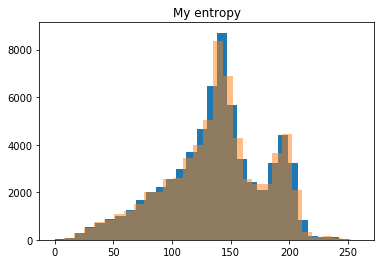

In [10]:
p = plt.subplot()
p.set_title('My entropy')
draw_entr(X, reconstr)
print()
print('data size before %i after %i'%(X.size,len(T.flatten())))
print('compression ratio',X.size/len(T.flatten()))

original entropy: 2.358917996821503
transformed entropy: 2.283086377870016
entropy loss: 0.07583161895148693

data size before 65536 after 3054
compression ratio 21.459070072036674


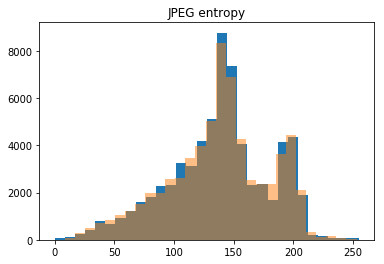

In [11]:
from os.path import getsize
p = plt.subplot()
p.set_title('JPEG entropy')
jimg = Image.fromarray(img, "L")
jimg.save('test.jpg', quality = 10)
jimg = np.array(Image.open('test.jpg'))
draw_entr(img, jimg)
s = getsize('test.jpg')
print()
print('data size before %i after %i'%(X.size,s))
print('compression ratio',X.size/s)

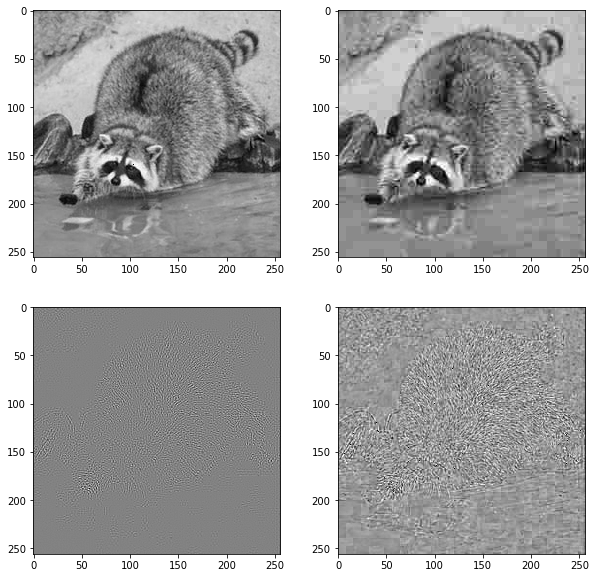

In [12]:
img2_p = img.astype(np.int16) - img2.astype(np.int16)
jimg_p = img.astype(np.int16) - jimg.astype(np.int16)
img2_p -= np.min(img2_p)
jimg_p -= np.min(jimg_p)
img2_p = img2_p.astype(np.uint8) * 2
jimg_p = jimg_p.astype(np.uint8) * 2
plot_images_table([img2,jimg,img2_p,jimg_p], columns=2)